In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp

In [3]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [5]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [6]:
from PIL import Image

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask is not None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split is not None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    print (confusion_matrix(ytest, clf.predict(Xtest)))
    print ("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [8]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [9]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax 

In [10]:
dfhw=pd.read_csv("01_heights_weights_genders.csv")
dfhw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [11]:
dfhw.shape

(10000, 3)

In [12]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

223

In [13]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([False,  True,  True, False,  True, False, False, False,  True,
        True])

using mask
BEST {'C': 0.001} 0.8966666666666666 {'mean_fit_time': array([0.00228734, 0.0005024 , 0.00110664, 0.0022018 , 0.00161104,
       0.0022099 , 0.00101147, 0.00218372]), 'std_fit_time': array([0.0021968 , 0.00063665, 0.00075698, 0.00107801, 0.00122341,
       0.0017672 , 0.00157264, 0.00170466]), 'mean_score_time': array([0.00000000e+00, 4.39882278e-04, 4.14276123e-04, 6.16455078e-04,
       4.64582443e-04, 2.42710114e-05, 1.61356926e-03, 5.14936447e-04]), 'std_score_time': array([0.00000000e+00, 8.79764557e-04, 5.07963025e-04, 5.04528114e-04,
       5.78361676e-04, 4.85420227e-05, 1.97631786e-03, 4.48095384e-04]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.93442623, 0.93442623, 0.9344

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\dell\appdata\local\programs\python\python37\lib\site-pa

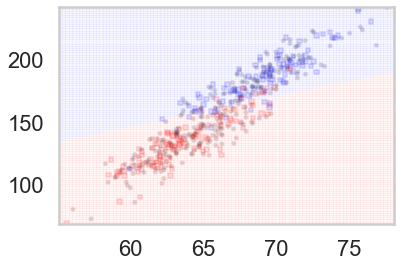

In [14]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

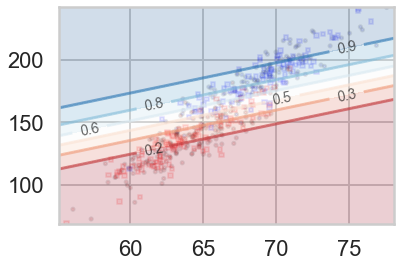

In [15]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [16]:
clflog.score(Xtest, ytest)

0.89

using mask


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'C': 100} 0.9033333333333333 {'mean_fit_time': array([1.19285583e-03, 2.25977898e-03, 1.19705200e-03, 8.90159607e-03,
       7.30587006e-02, 7.15171862e-01, 1.36979475e+00]), 'std_fit_time': array([0.00187244, 0.00203526, 0.00156252, 0.0018681 , 0.03245701,
       0.44510939, 0.60187172]), 'mean_score_time': array([0.00020056, 0.00036597, 0.00080147, 0.0009408 , 0.00081148,
       0.00055661, 0.00032492]), 'std_score_time': array([0.00040112, 0.00073195, 0.00160294, 0.00143515, 0.00162296,
       0.00045704, 0.00041793]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.90163934, 0.91803279, 0.93442623, 0.93442623, 0.93442623,
       0.93442623, 0.90163934]), 'split1_test_score': array([0.91666667, 0.91666667, 0.91666667

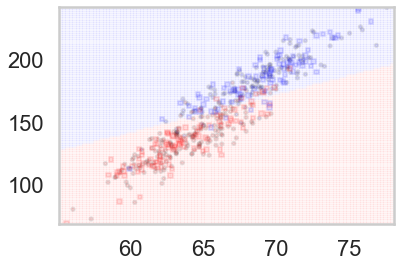

In [17]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [18]:
clfsvm.decision_function(Xtest)

array([-3.52187251,  1.32405108,  1.29508251,  1.57067837, -1.50332648,
       -0.36697525, -4.4195282 ,  4.67023153,  0.63132223, -5.03820384,
        3.86276612,  1.53653775,  2.59051276,  1.79774161,  1.07324894,
        2.90107335,  2.46654736, -2.66273363, -1.7066805 , -1.89745044,
       -1.60978852, -7.38909602, -3.74157893, -4.02826669,  0.01299005,
        1.11745595, -1.57797379,  0.59197527,  3.56428399,  1.72394831,
       -1.98903504,  4.36644293, -2.86746828, -2.84904671, -2.04753803,
        2.72238742,  1.746639  , -2.11992813,  0.69511778,  0.69902057,
       -1.95372085, -2.63518472, -1.77760551,  1.89968465,  4.29951294,
       -4.33962722, -0.98819706,  3.07062931, -4.0819179 , -3.95011871,
       -2.35959727, -1.90649896,  1.28929392, -3.83839155, -2.69232406,
       -2.28274845, -2.35937783,  3.05295876, -2.71878549, -0.9134338 ,
        0.90899507,  1.16982951, -4.04687043,  4.07831012, -1.42449382,
        0.05506362,  4.75581147, -0.14495954,  7.23784478, -0.91

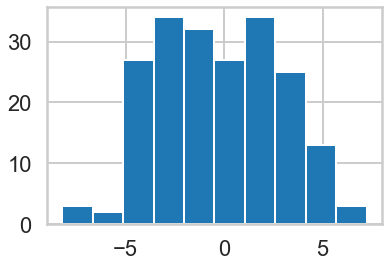

In [19]:
plt.hist(clfsvm.decision_function(Xtest));

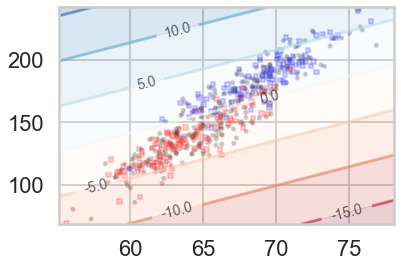

In [20]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [21]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[55.16820212 68.48253009].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

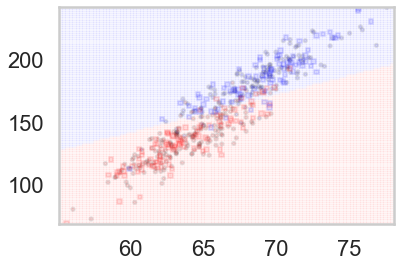

In [22]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

In [23]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[97, 11],
       [11, 81]], dtype=int64)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       108
           1       0.88      0.88      0.88        92

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



In [25]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [26]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[36, 72],
       [ 1, 91]], dtype=int64)

In [27]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

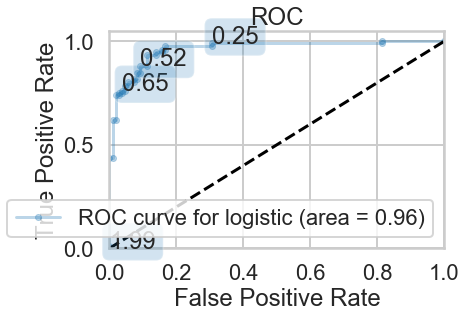

In [28]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

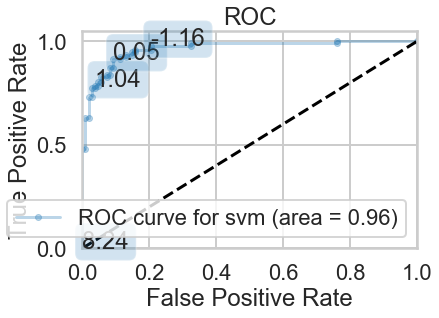

In [29]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)